In [ ]:
from google.colab import drive


drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        # Reads the CSV file using pandas.
        # .values converts the DataFrame to a NumPy array for easier processing.
        data = pd.read_csv(csv_file).values

        # Extracts pixel data (all columns except the first one) and normalizes it
        # by dividing by 255.0 to scale values between 0 and 1.
        self.X = torch.tensor(data[:, 1:] / 255.0, dtype=torch.float32)

        # Extracts labels (the first column)
        self.y = torch.tensor(data[:, 0], dtype=torch.long)

    def __len__(self):
        # Returns the total number of samples in the dataset.
        return len(self.y)

    def __getitem__(self, idx):
        # Returns a single sample (image and its corresponding label) given an index.
        return self.X[idx], self.y[idx]

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):

        return self.model(x)

In [ ]:
# Function to perform one training epoch
def train(model, dataloader, loss_fn, optimizer, device):
    model.train() # Set the model to training mode
    total_loss = 0
    for X, y in dataloader:
        # Move data to the specified device (CPU or GPU)
        X, y = X.to(device), y.to(device)

        # Zero the gradients accumulated from the previous step
        optimizer.zero_grad()

        # Perform a forward pass to get predictions
        preds = model(X)

        # Calculate the loss
        loss = loss_fn(preds, y)

        # Perform a backward pass to compute gradients
        loss.backward()

        # Update model parameters based on gradients
        optimizer.step()

        total_loss += loss.item() # Accumulate the loss

    return total_loss / len(dataloader) # Return average loss for the epoch

# Function to evaluate the model's accuracy
def evaluate(model, dataloader, device):
    model.eval() # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculations for efficiency
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item() # Count correct predictions
            total += y.size(0) # Count total samples

    return correct / total

In [ ]:
def show_prediction(dataset, model, device, index):
    model.eval()
    # Get the image and label from the dataset
    image = dataset.X[index].to(device)
    label = dataset.y[index].item()

    with torch.no_grad():
        # Make a prediction (unsqueeze(0) adds a batch dimension, as model expects batches)
        output = model(image.unsqueeze(0))
        predicted = torch.argmax(output, 1).item() # Get the predicted class

    # Plot the image
    plt.imshow(image.cpu().reshape(28, 28), cmap='gray')
    plt.title(f'True: {label}, Predicted: {predicted}')
    plt.axis('off')
    plt.show()

Using device: cuda
Starting training...
Epoch 1: Train Loss = 0.3735, Train Acc = 0.9496, Test Acc = 0.9433
Epoch 2: Train Loss = 0.1554, Train Acc = 0.9671, Test Acc = 0.9583
Epoch 3: Train Loss = 0.1048, Train Acc = 0.9779, Test Acc = 0.9649
Epoch 4: Train Loss = 0.0789, Train Acc = 0.9845, Test Acc = 0.9701
Epoch 5: Train Loss = 0.0617, Train Acc = 0.9885, Test Acc = 0.9715
Epoch 6: Train Loss = 0.0460, Train Acc = 0.9882, Test Acc = 0.9715
Epoch 7: Train Loss = 0.0376, Train Acc = 0.9910, Test Acc = 0.9737
Epoch 8: Train Loss = 0.0304, Train Acc = 0.9941, Test Acc = 0.9749
Epoch 9: Train Loss = 0.0243, Train Acc = 0.9928, Test Acc = 0.9712
Epoch 10: Train Loss = 0.0204, Train Acc = 0.9931, Test Acc = 0.9706
Epoch 11: Train Loss = 0.0187, Train Acc = 0.9960, Test Acc = 0.9741
Epoch 12: Train Loss = 0.0166, Train Acc = 0.9944, Test Acc = 0.9716
Epoch 13: Train Loss = 0.0149, Train Acc = 0.9961, Test Acc = 0.9739
Epoch 14: Train Loss = 0.0153, Train Acc = 0.9950, Test Acc = 0.9740
Epo

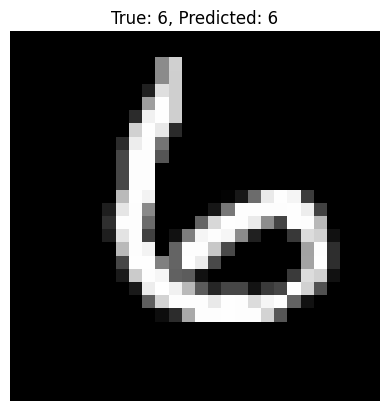

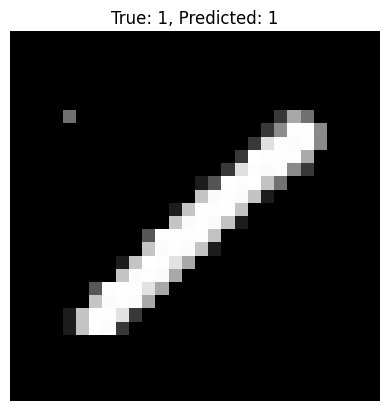

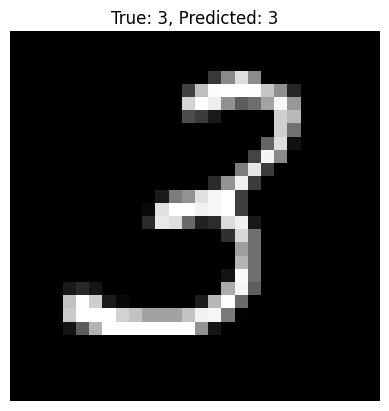

In [ ]:
def main():

    csv_path = '/content/drive/MyDrive/mnist_train.csv'

    # Check if the file exists
    import os
    if not os.path.exists(csv_path):
        print(f"Error: CSV file not found at {csv_path}. Please check your Google Drive mount and file path.")
        return

    dataset = MNISTDataset(csv_path)

    # Train/Test split (80/20)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_data, test_data = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}") # Print which device is being used
    model = SimpleNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    print("Starting training...")
    for epoch in range(100):
        train_loss = train(model, train_loader, loss_fn, optimizer, device)
        train_acc = evaluate(model, train_loader, device)
        test_acc = evaluate(model, test_loader, device)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
    print("Training complete.")

    # Visualize a few test predictions
    print("\n Sample predictions on test set:")
    for i in range(3):
        show_prediction(dataset, model, device, test_data.indices[i])

if __name__ == '__main__':
    main()